Agatha Justina Majcher  
M.Sc. Renewable Energy Systems

# Distributional Analysis of the Carbon Tax in South Africa

Part II - PyPSA-ZA  
Revenue Recycling through Investment in Renewable Energies

# 1. Setup

In [1]:
import sys
sys.path.append("~/Desktop/pypsa-za-master")

In [2]:
import pypsa
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use("bmh")
%matplotlib inline

In [3]:
import pandas as pd
import geopandas as gpd
import numpy
import cartopy.crs as ccrs
import matplotlib as mpl
from matplotlib.patches import Circle, Ellipse
from matplotlib.legend_handler import HandlerPatch
from vresutils import plot as vplot
from vresutils import Dict

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
pd.set_option('display.max_columns', None)

In [6]:
# setup for plots
colors = {
    "onwind": "#77D1E4",
    "hydro": "#004F95",
    "hydro-import": "#004F95",
    "CSP": "#FEED82",
    "solar": "#FFBB4E",
    "biomass": "#0c6013",
    "CCGT": "#CCC8C8",
    "OCGT": "#8D7867",
    "nuclear": "#C84936",
    "gas": "grey",
    "coal": "#3C3C3C",
}

nice_names = {
    'nuclear': 'Nuclear',
    'coal': 'Coal',
    'CCGT': 'CCGT',
    'OCGT': 'OCGT',
    'gas': 'Gas',
    'onwind': 'Wind',
    'hydro': 'Hydro',
    'hydro-import': 'Hydro Import',
    'solar': 'PV',
    'CSP': 'CSP',
    'biomass': 'Biomass',
}

In [5]:
# solved_network files

n275 = pypsa.Network("~/Desktop/final_networks/solved_val-2Gt-IRP_27-supply_redz_lcopt_Co2L-1H_275oc.nc") #275Mt

INFO:pypsa.io:Imported network solved_val-2Gt-IRP_27-supply_redz_lcopt_Co2L-1H_275oc.nc has buses, carriers, generators, global_constraints, lines, loads, storage_units


In [8]:
neu = pypsa.Network("~/Desktop/final_networks/solved_val-2Gt-IRP_27-supply_redz_lcopt_Co2L-1H-59.nc") #275Mt + 3.19bUS$


INFO:pypsa.io:Imported network solved_val-2Gt-IRP_27-supply_redz_lcopt_Co2L-1H-59.nc has buses, carriers, generators, global_constraints, lines, loads, storage_units


In [70]:
n100 = pypsa.Network("~/Desktop/final_networks/solved_val-2Gt-IRP_27-supply_redz_lcopt_Co2L-1H-100.nc") #100Mt


INFO:pypsa.io:Imported network solved_val-2Gt-IRP_27-supply_redz_lcopt_Co2L-1H-100.nc has buses, carriers, generators, global_constraints, lines, loads, storage_units


In [67]:
for c in n8.iterate_components(list(n8.components.keys())[2:]):
    print("Component '{}' has {} entries".format(c.name,len(c.df)))

Component 'Bus' has 27 entries
Component 'Carrier' has 12 entries
Component 'GlobalConstraint' has 17 entries
Component 'Line' has 120 entries
Component 'LineType' has 34 entries
Component 'TransformerType' has 14 entries
Component 'Load' has 27 entries
Component 'Generator' has 695 entries
Component 'StorageUnit' has 328 entries


# 2. Capacity

In [33]:
# Group generator capacities by carrier before optimization
gen_capacities_by_carrier_before = neu.generators.groupby('carrier')['p_nom'].sum()

# Group generator capacities by carrier after optimization
gen_capacities_by_carrier_after = neu.generators.groupby('carrier')['p_nom_opt'].sum()

# Display the grouped generator capacities before and after optimization
print("Generator capacities by carrier before optimization:")
print(gen_capacities_by_carrier_before/1000)
print(gen_capacities_by_carrier_before.sum()/1000)

print("\nGenerator capacities by carrier after optimization:")
print(gen_capacities_by_carrier_after/1000)
print(gen_capacities_by_carrier_after.sum()/1000)

Generator capacities by carrier before optimization:
carrier
CCGT                 0.00000
CSP                  0.60000
OCGT                 0.00000
biomass              0.19306
coal                40.28400
gas                  3.84400
hydro                0.68302
hydro-import         1.76400
load_shedding    27000.00000
nuclear              1.85400
onwind               5.19059
solar                4.04707
Name: p_nom, dtype: float64
27058.45974

Generator capacities by carrier after optimization:
carrier
CCGT                 0.000000
CSP                  0.600000
OCGT                11.198407
biomass              0.193060
coal                40.284000
gas                  3.844000
hydro                0.683020
hydro-import         1.764000
load_shedding    27000.000000
nuclear              1.854000
onwind              25.846859
solar               23.361655
Name: p_nom_opt, dtype: float64
27109.62900081686


# 3. Generation

In [104]:
neu.generators_t.p.sum().groupby(neu.generators.carrier).sum()

carrier
CCGT             0.000000e+00
CSP              1.986336e+06
OCGT             2.191150e+05
biomass          9.567008e+05
coal             1.171427e+08
gas              4.830063e+05
hydro            3.529179e+06
hydro-import     9.317461e+06
load_shedding    0.000000e+00
nuclear          1.347808e+07
onwind           8.669694e+07
solar            4.454777e+07
dtype: float64

In [105]:
# Total generation in GWh
neu.generators_t.p.sum().sum()/1e3

278357.2877863114

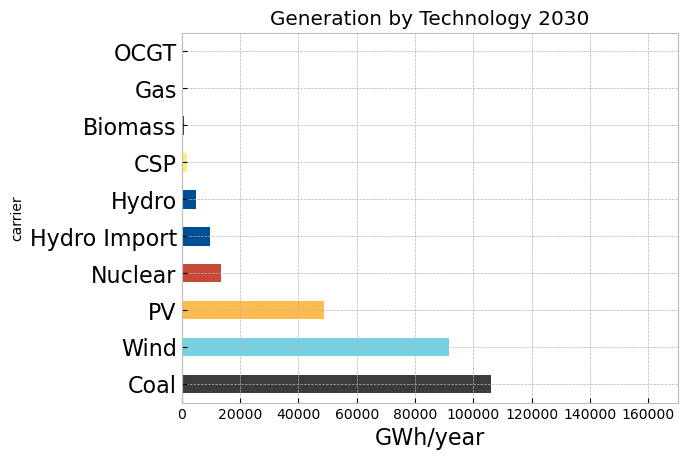

In [92]:
# Group by carrier and sum p_nom, divide by 1000 to convert to GW
a = n100.generators_t.p.sum().groupby(n100.generators.carrier).sum().div(1e3)
a = a[a != 0] 

carrier_order = ['onwind', 'solar', 'CSP', 'hydro', 'hydro-import', 'biomass', 'gas', 'OCGT', 'nuclear', 'coal']
a_sorted = a.loc[carrier_order].sort_values(ascending=False)

# Create horizontal bar chart
ax = a_sorted.plot.barh(color=[colors.get(carrier, '#333333') for carrier in a_sorted.index])
ax.set_xlabel('GWh/year', fontsize=16)
ax.set_title('Generation by Technology 2030')

ax.set_facecolor('white')

# Replace carrier names with nice names
ax.set_yticklabels([nice_names.get(label.get_text(), label.get_text()) for label in ax.get_yticklabels()],fontsize=16)

ax.set_xlim(0, 170000)

# Save plot as PNG
plt.savefig('gen_100.png', dpi=600,facecolor='white', bbox_inches='tight')

plt.show()

#### Generated Electricity per Day

In [93]:
# power (MWh) sum of 8760h /24 - MWh per day /1000 - GW per day
p_by_carrier = n100.generators_t.p.groupby(n100.generators.carrier, axis=1).sum()
p_by_carrier = p_by_carrier.droplevel(level='period')
p_by_carrier = p_by_carrier.drop(columns=["load_shedding"])

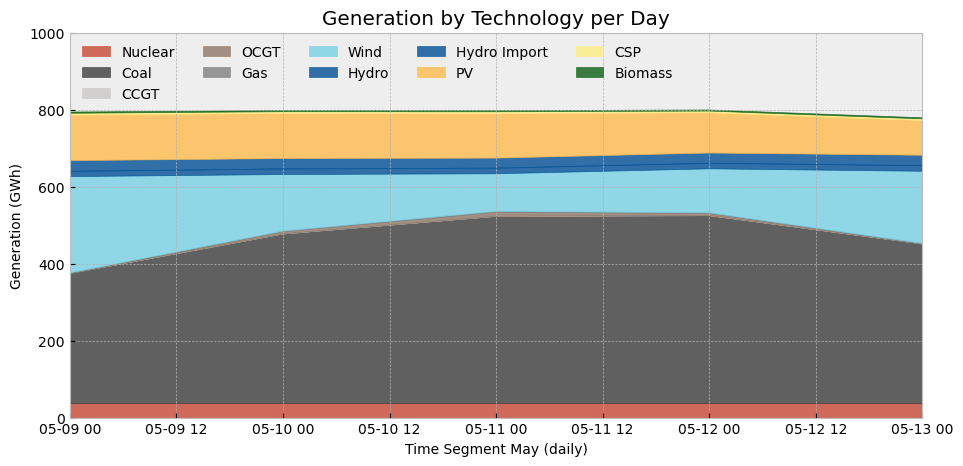

In [95]:
p_by_carrier_resampled = p_by_carrier.resample("D").sum()/1e3
stacked = p_by_carrier_resampled.stack().reset_index()
stacked.columns = ['week', 'carrier', 'GW']
stacked = stacked.pivot(index='week', columns='carrier', values='GW')
bottom = 0


fig, ax = plt.subplots(figsize=(11, 5))
bottom = 0
for carrier in nice_names:
    data = stacked[carrier]
    ax.fill_between(
        data.index, bottom, bottom + data, 
        color=colors[carrier], alpha=0.8, label=nice_names[carrier]
    )
    bottom += data

# add legend and axis labels
ax.set_xlim(pd.Timestamp('2030-05-09'), pd.Timestamp('2030-05-13'))
ax.legend(ncol=5, loc="upper left", frameon=False)
ax.set_xlabel("Time Segment May (daily)")
ax.set_ylabel("Generation (GWh)")
ax.set_title("Generation by Technology per Day")
ax.set_ylim(0,1000);

# Save plot as PNG
plt.savefig('time_generation100_2.png', dpi=600,facecolor='white', bbox_inches='tight')

plt.show()

# 4. Storage

In [83]:
a = n275.storage_units_t.p.sum()
a = a.loc[a != 0]
a.head(20)

StorageUnit
BLOEMFONTEIN battery_2030      5.123568e-12
Drakensberg                   -1.958203e+05
Ingula                        -6.661089e+05
KAROO battery_2030            -2.957976e-10
KIMBERLEY battery_2028        -1.615873e-10
KIMBERLEY battery_2030        -8.136514e-11
LADYSMITH battery_2030        -5.761719e-11
LOWVELD battery_2030           8.602452e-12
NAMAQUALAND battery_2030      -1.818649e+05
NEWCASTLE battery_2030        -5.487754e-10
PENINSULA battery_2030         7.958079e-13
PORT ELIZABETH battery_2030    6.451728e-11
Palmiet                       -1.384101e+05
RUSTENBURG battery_2030       -2.762629e-11
Steenbras                     -3.106175e+02
WARMBAD battery_2030          -2.190623e-11
WATERBERG battery_2030         1.832780e-11
WELKOM battery_2030           -2.886111e-10
dtype: float64

In [91]:
b= n100.storage_units.p_nom_opt
b= b.loc[b != 0]
b

StorageUnit
Drakensberg    1000.0
Ingula         1332.0
Palmiet         400.0
Steenbras       180.0
Name: p_nom_opt, dtype: float64

In [26]:
b.sum()

2912.0

In [365]:
# Before optimization
storage_units_before = n96.storage_units.p_nom

# After optimization
storage_units_after = n96.storage_units.p_nom_opt

print("Total storage capacity for Storage Units before optimization:", storage_units_before.sum())
print("Total storage capacity for Storage Units after optimization:", storage_units_after.sum())


Total storage capacity for Storage Units before optimization: 2912.0
Total storage capacity for Storage Units after optimization: 2912.0


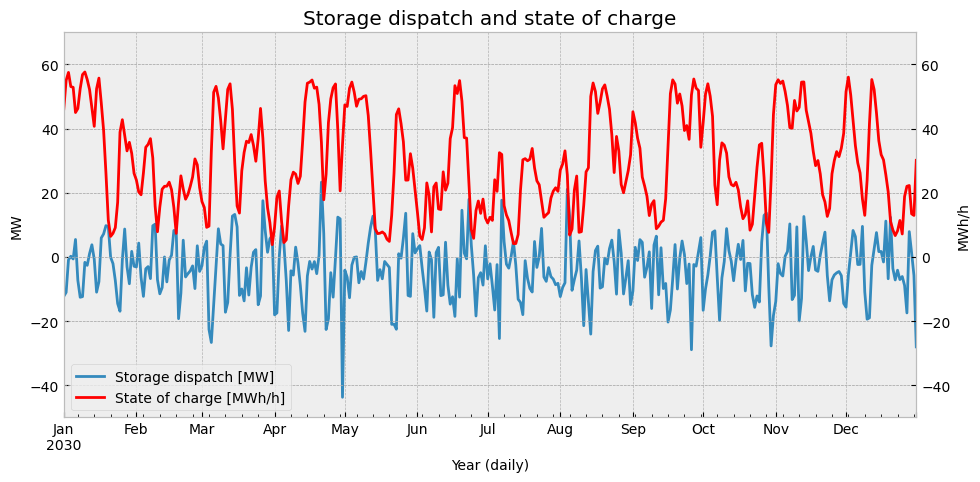

In [39]:
fig, ax = plt.subplots(figsize=(11, 5))

p_storage = neu.storage_units_t.p.sum(axis=1).div(1e3)
p_storage = p_storage.droplevel(level='period')
p_storage = p_storage.resample("D").sum()
state_of_charge = n100.storage_units_t.state_of_charge.sum(axis=1).div(1e3)/24
state_of_charge = state_of_charge.droplevel(level='period')
state_of_charge = state_of_charge.resample("D").sum()

p_storage.plot(label="Storage dispatch [MW]", ax=ax, ylabel="MW")

ax2 = ax.twinx()
ax2.plot(state_of_charge, label="State of charge [MWh/h]", color="red")
ax2.set_ylabel("MWh/h")

ax.set_ylim([-50, 70])
ax2.set_ylim([-50, 70])

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2)
ax.set_xlabel("Year (daily)")

ax.grid(True)
plt.title("Storage dispatch and state of charge")
plt.savefig("storage_neu.png")

# 5. Transmission Lines

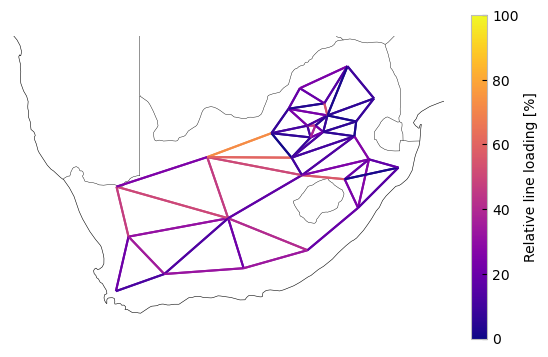

In [96]:
map_boundaries = [14, 34, -35, -22] 

line_loading = n100.lines_t.p0.iloc[0].abs() / n100.lines.s_nom_opt / n100.lines.s_max_pu * 100 # %

norm = plt.Normalize(vmin=0, vmax=100)

fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection=ccrs.PlateCarree())

n100.plot(
    ax=ax,
    bus_sizes=0,
    line_colors=line_loading,
    line_norm=norm,
    line_cmap='plasma',
    line_widths=1.5,
    boundaries=map_boundaries
);

plt.colorbar(
    plt.cm.ScalarMappable(cmap='plasma', norm=norm),
    label='Relative line loading [%]',
    shrink=0.6
)

plt.savefig("networkload_100.png")

### Transmission Line Expansion

In [43]:
from matplotlib.colors import LinearSegmentedColormap

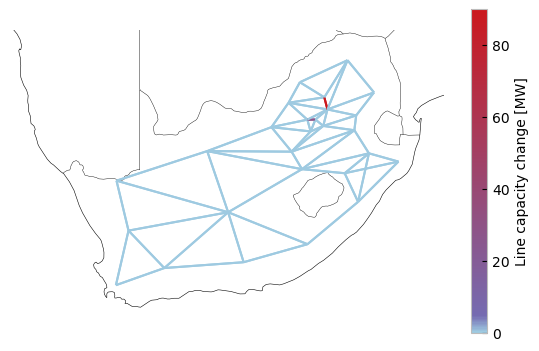

In [97]:
map_boundaries = [14, 34, -35, -22] 

custom_cmap = LinearSegmentedColormap.from_list(
    'custom', [(0, '#9ecae1'), (0.05, '#756bb1'), (1, '#cb181d')])

line_dif = (n100.lines.s_nom_opt - n100.lines.s_nom_min)

norm = plt.Normalize(vmin=line_dif.min(), vmax=90)

fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection=ccrs.PlateCarree())

n100.plot(
    ax=ax,
    bus_sizes=0,
    line_colors=line_dif,
    line_norm=norm,
    line_cmap=custom_cmap,
    line_widths=1.5,
    boundaries=map_boundaries
);

plt.colorbar(
    plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm),
    label='Line capacity change [MW]',
    shrink=0.6
)

plt.savefig("networknew_n100.png")

In [98]:
line_dif.sort_values(ascending=False)

Line
97     9.598428e+01
108    9.598428e+01
91     2.730704e+01
57     2.730704e+01
72     4.789363e-07
           ...     
77    -4.110814e-07
14    -4.318281e-07
31    -4.318281e-07
73    -4.664889e-07
81    -4.664889e-07
Length: 120, dtype: float64

In [347]:
unique_line_types = n96.lines.type.unique()
print("Unique line types:", unique_line_types)


Unique line types: ['Al/St 240/40 4-bundle 380.0']


In [73]:
prices= n100.buses_t.marginal_price.mean().groupby(bus_type).mean().mean()
prices

569.9761495254485

# 6. Links

In [93]:
n8.links

attribute,bus0,bus1,type,carrier,efficiency,build_year,lifetime,p_nom,p_nom_extendable,p_nom_min,p_nom_max,p_set,p_min_pu,p_max_pu,capital_cost,marginal_cost,length,terrain_factor,ramp_limit_up,ramp_limit_down,p_nom_opt
Link,,,,,,,,,,,,,,,,,,,,,


# 7. Marginal Price

In [77]:
n275.buses_t.marginal_price.head(5)

Bus                         NAMAQUALAND  WEST COAST   PENINSULA  \
period timestep                                                   
2030   2030-01-01 00:00:00   469.666632  469.666632  469.666632   
       2030-01-01 01:00:00   447.875343  447.875343  447.875343   
       2030-01-01 02:00:00   469.666959  469.666959  469.666959   
       2030-01-01 03:00:00   462.402978  462.402978  462.402978   
       2030-01-01 04:00:00   462.406578  462.406578  462.406578   

Bus                         SOUTHERN CAPE  PORT ELIZABETH       KAROO  \
period timestep                                                         
2030   2030-01-01 00:00:00     469.666632      469.666632  469.666632   
       2030-01-01 01:00:00     447.875343      447.875343  447.875343   
       2030-01-01 02:00:00     469.666959      469.666959  469.666959   
       2030-01-01 03:00:00     462.402978      462.402978  462.402978   
       2030-01-01 04:00:00     462.406578      462.406578  462.406578   

Bus                          KIMBERLEY  CARLETONVILLE      WELKOM  \
period timestep                                                     
2030   2030-01-01 00:00:00  469.666632     469.666632  469.666632   
       2030-01-01 01:00:00  447.875343     447.875343  447.875343   
       2030-01-01 02:00:00  469.666959     469.666959  469.666959   
       2030-01-01 03:00:00  462.402978     462.402978  462.402978   
       2030-01-01 04:00:00  462.406578     462.406578  462.406578   

Bus                         BLOEMFONTEIN  ...   POLOKWANE     WARMBAD  \
period timestep                           ...                           
2030   2030-01-01 00:00:00    469.666632  ...  469.666632  469.666632   
       2030-01-01 01:00:00    447.875343  ...  447.875343  447.875343   
       2030-01-01 02:00:00    469.666959  ...  469.666959  469.666959   
       2030-01-01 03:00:00    462.402978  ...  462.402978  462.402978   
       2030-01-01 04:00:00    462.406578  ...  462.406578  462.406578   

Bus                           PRETORIA  JOHANNESBURG       NIGEL  \
period timestep                                                    
2030   2030-01-01 00:00:00  469.666632    469.666632  469.666632   
       2030-01-01 01:00:00  447.875343    447.875343  447.875343   
       2030-01-01 02:00:00  469.666959    469.666959  469.666959   
       2030-01-01 03:00:00  462.402978    462.402978  462.402978   
       2030-01-01 04:00:00  462.406578    462.406578  462.406578   

Bus                         HIGHVELD SOUTH  HIGHVELD NORTH     LOWVELD  \
period timestep                                                          
2030   2030-01-01 00:00:00      469.666632      469.666632  469.666632   
       2030-01-01 01:00:00      447.875343      447.875343  447.875343   
       2030-01-01 02:00:00      469.666959      469.666959  469.666959   
       2030-01-01 03:00:00      462.402978      462.402978  462.402978   
       2030-01-01 04:00:00      462.406578      462.406578  462.406578   

Bus                          NEWCASTLE   EMPANGENI  
period timestep                                     
2030   2030-01-01 00:00:00  469.666632  469.666632  
       2030-01-01 01:00:00  447.875343  447.875343  
       2030-01-01 02:00:00  469.666959  469.666959  
       2030-01-01 03:00:00  462.402978  462.402978  
       2030-01-01 04:00:00  462.406578  462.406578  

[5 rows x 27 columns]

In [42]:
bus_type = pd.Series(n275.buses.index.str[0:],n275.buses.index).replace("","electricity")

In [80]:
prices= n275.buses_t.marginal_price.mean().groupby(bus_type).mean()
prices.mean()

543.728116615548

In [81]:
prices= n100.buses_t.marginal_price.mean().groupby(bus_type).mean()
prices.mean()

569.9761495254485

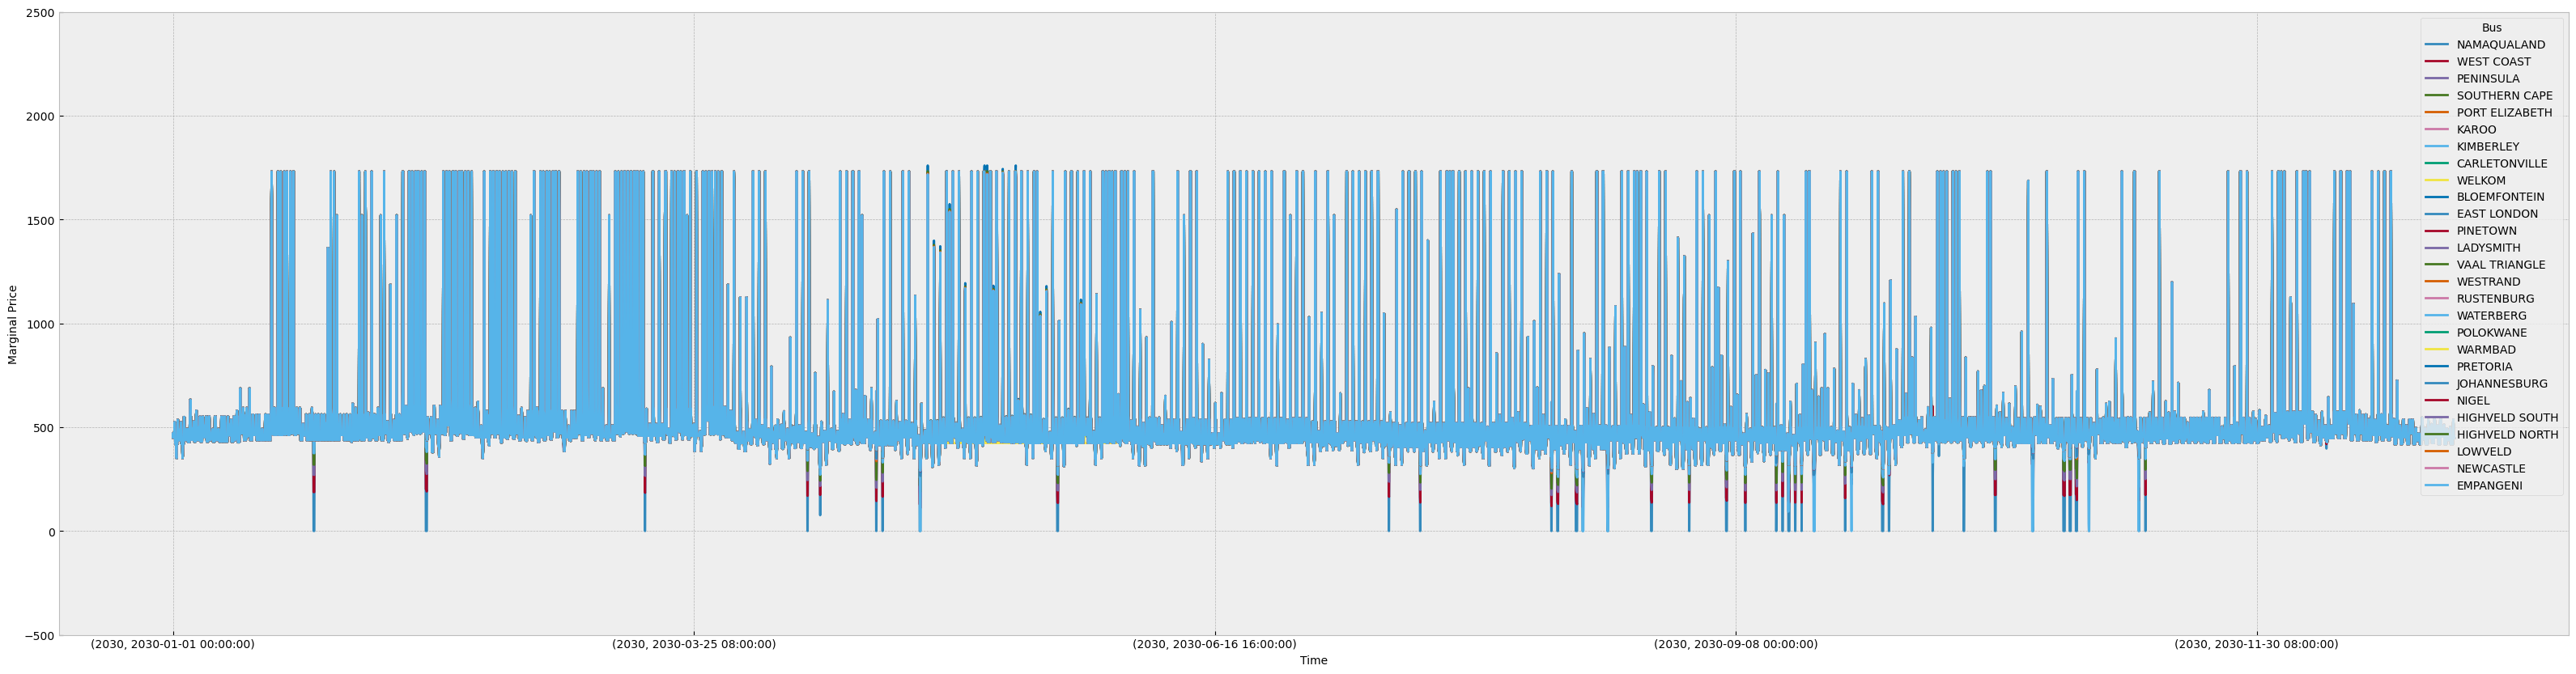

In [79]:
import matplotlib.pyplot as plt

# Set figure size
fig, ax = plt.subplots(figsize=(40, 10))

# Assuming n is your Network object and you have run lopf with keep_shadowprices=True
df = n275.buses_t.marginal_price

# Transpose the DataFrame so that each bus is a separate line in the plot
#df = df.transpose()

# Plotting the data on the created axis
df.plot(kind='line', legend=True, ax=ax)  # use legend=True if you want to display the legend

ax.set_ylabel('Marginal Price')
ax.set_xlabel('Time')

# Set the y limit
ax.set_ylim(-500,2500)

plt.show()

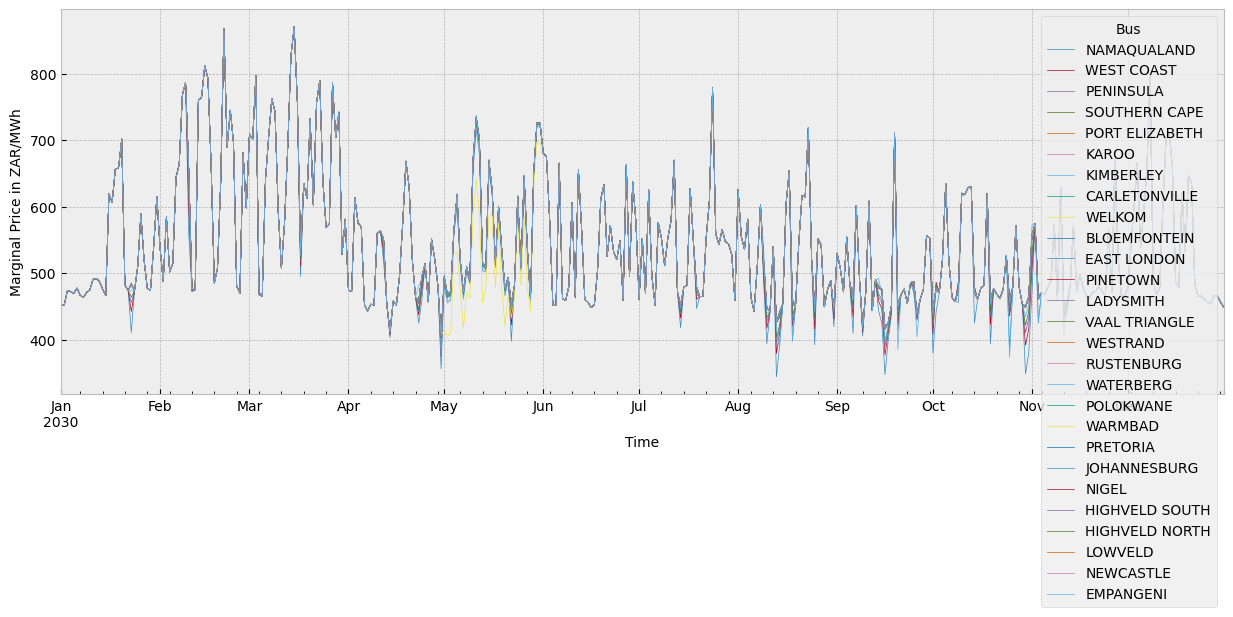

In [67]:
df = n275.buses_t.marginal_price.reset_index()

# Convert the 'timestep' column to datetime type
df['timestep'] = pd.to_datetime(df['timestep'])

# Set 'timestep' as the index
df.set_index('timestep', inplace=True)

df = df.drop(columns='period')

# Now you should be able to resample
df_daily = df.resample('D').mean()

# Plotting the data
df_daily.plot(kind='line', legend=True, figsize=(15,5), linewidth=0.5)
plt.ylabel('Marginal Price in ZAR/MWh')
plt.xlabel('Time')

# Save plot as PNG
plt.savefig('marginal_price.png', dpi=600,facecolor='white', bbox_inches='tight')

plt.show()


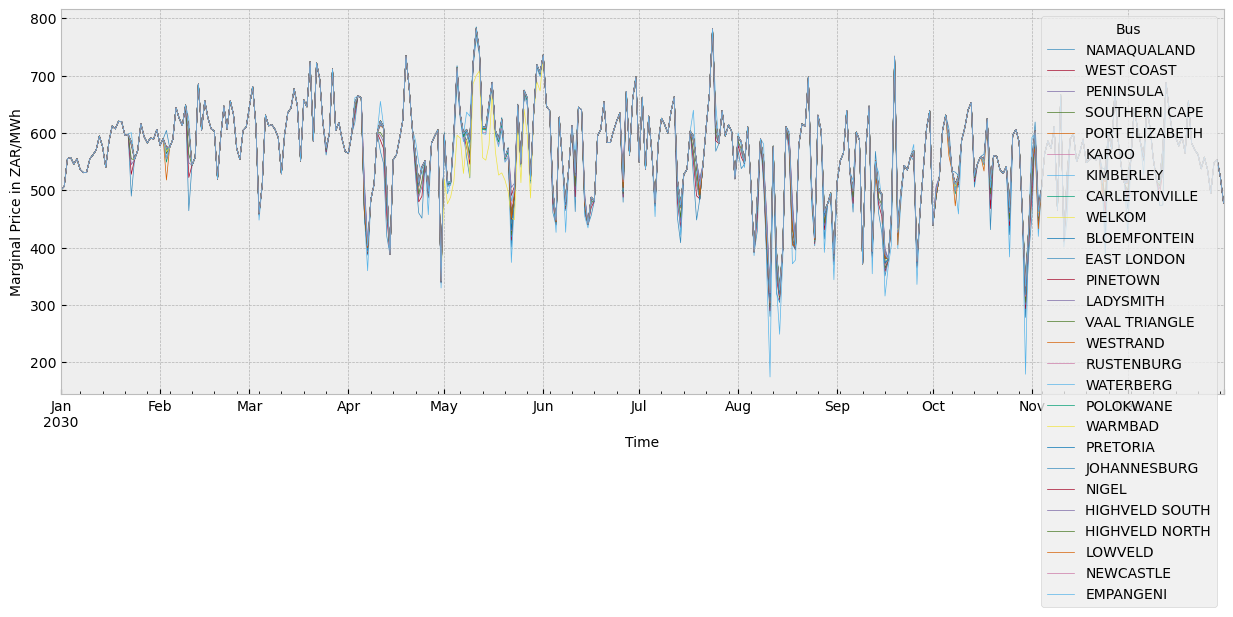

In [71]:
df = n100.buses_t.marginal_price.reset_index()

# Convert the 'timestep' column to datetime type
df['timestep'] = pd.to_datetime(df['timestep'])

# Set 'timestep' as the index
df.set_index('timestep', inplace=True)

df = df.drop(columns='period')

# Now you should be able to resample
df_daily = df.resample('D').mean()

# Plotting the data
df_daily.plot(kind='line', legend=True, figsize=(15,5), linewidth=0.5)
plt.ylabel('Marginal Price in ZAR/MWh')
plt.xlabel('Time')

# Save plot as PNG
plt.savefig('marginal_price.png', dpi=600,facecolor='white', bbox_inches='tight')

plt.show()

# 8. Total Annual System Costs

In [48]:
neu.objective/1e9/17.673

13.001306415727885

In [49]:
def aggregate_costs(n, flatten=False, opts=None, existing_only=False):
    components = dict(
        Link=("p_nom", "p0"),
        Generator=("p_nom", "p"),
        StorageUnit=("p_nom", "p"),
        Store=("e_nom", "p"),
        Line=("s_nom", None),
        Transformer=("s_nom", None),
    )

    costs = {}
    for c, (p_nom, p_attr) in zip(
        n.iterate_components(components.keys(), skip_empty=False), components.values()
    ):
        if c.df.empty:
            continue
        if not existing_only:
            p_nom += "_opt" #only p_nom before optimazation
        costs[(c.list_name, "capital")] = (
            (c.df[p_nom] * c.df.capital_cost).groupby(c.df.carrier).sum()
        )
        if p_attr is not None:
            p = c.pnl[p_attr].sum()
            if c.name == "StorageUnit":
                p = p.loc[p > 0]
            costs[(c.list_name, "marginal")] = (
                (p * c.df.marginal_cost).groupby(c.df.carrier).sum()
            )
    costs = pd.concat(costs)

    if flatten:
        assert opts is not None
        conv_techs = opts["conv_techs"]

        costs = costs.reset_index(level=0, drop=True)
        costs = costs["capital"].add(
            costs["marginal"].rename({t: t + " marginal" for t in conv_techs}),
            fill_value=0.0,
        )

    return costs

In [50]:
costs_df = aggregate_costs(neu, flatten=False, opts=None, existing_only=False)


In [55]:
costs_df/1e6/17.673

                         carrier      
generators     capital   CCGT                0.000000
                         CSP               356.461213
                         OCGT              740.929649
                         biomass           109.114866
                         coal             2533.847790
                         gas                36.382561
                         hydro               0.000000
                         hydro-import        0.000000
                         load_shedding       0.000000
                         nuclear           124.523171
                         onwind           2296.703291
                         solar             893.304065
               marginal  CCGT                0.000000
                         CSP                 0.001122
                         OCGT               21.459693
                         biomass             0.000536
                         coal             2327.521032
                         gas               

# 9. CO2 Emissions

In [412]:
#### Total CO2 emissions by the network (efficiency and fuel source)

In [56]:
emissions = neu.generators_t.p / neu.generators.efficiency * neu.generators.carrier.map(neu.carriers.co2_emissions)
emissions.sum().sum() / 1e6 #Mt

111.14384044130131

In [99]:
e = (n100.generators_t.p/n100.generators.efficiency*n100.generators.carrier.map(n100.carriers.co2_emissions)).sum()
e_carrier = e.groupby(n100.generators.carrier).sum()/1e6

In [100]:
e_carrier.rename(index={'OCGT': 'gas'}, inplace=True)

In [101]:
e_carrier = e_carrier.groupby('carrier').sum()

In [102]:
e_carrier

carrier
CCGT              0.000000
CSP               0.000000
biomass           0.000000
coal             99.661018
gas               0.338983
hydro             0.000000
hydro-import      0.000000
load_shedding     0.000000
nuclear           0.000000
onwind            0.000000
solar             0.000000
dtype: float64

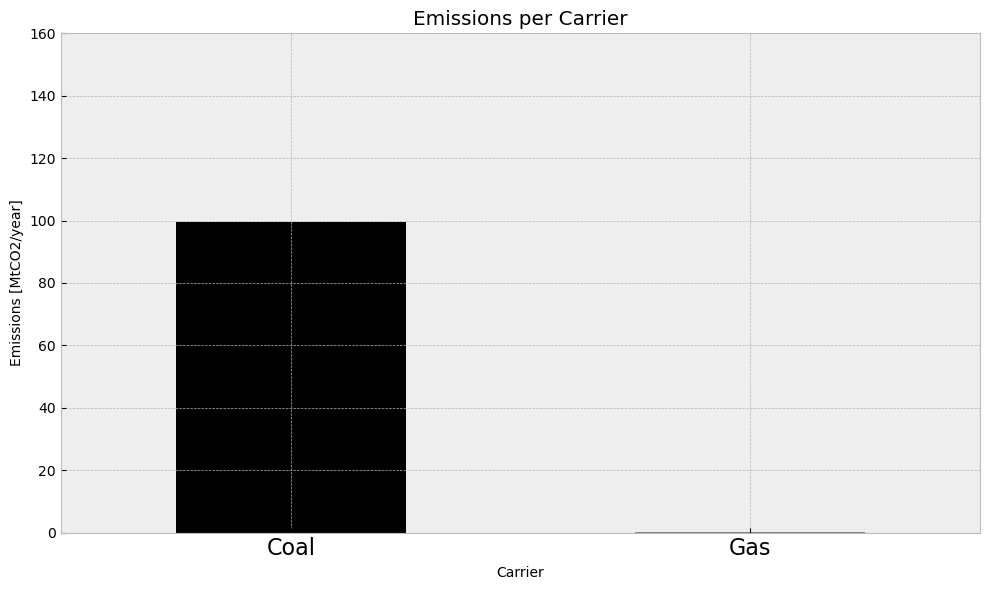

In [103]:
e_carrier = e_carrier.loc[lambda x: x != 0]

fig, ax = plt.subplots(figsize=(10, 6))
e_carrier.plot(kind="bar", ax=ax, rot=0, color=["black", "grey"])

ax.set_xlabel("Carrier")
ax.set_ylabel("Emissions [MtCO2/year]")
ax.set_title("Emissions per Carrier")

ax.set_xticklabels([nice_names.get(label.get_text(), label.get_text()) for label in ax.get_xticklabels()],fontsize=16)

ax.set_ylim(0, 160)

plt.tight_layout()
plt.savefig("emissions_per_carrier100.png")

In [318]:
#### Plot total CO2 emissions per day

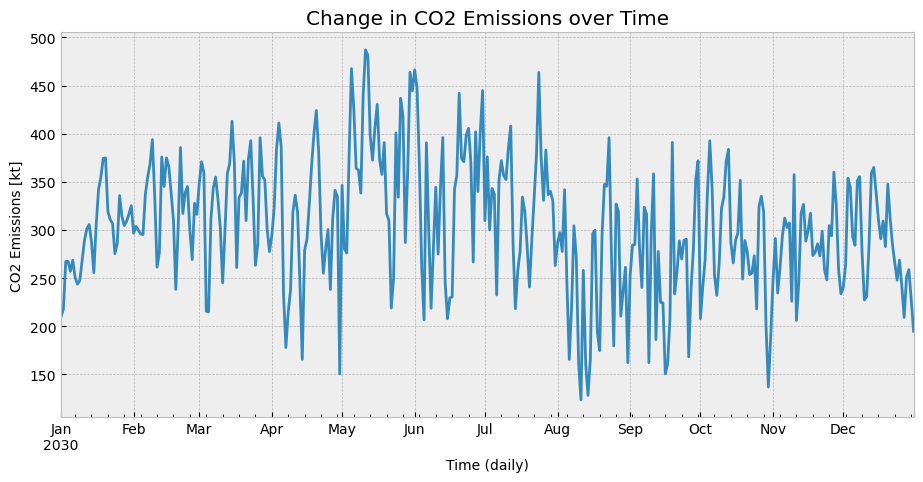

In [67]:
emissions = (neu.generators_t.p / neu.generators.efficiency * neu.generators.carrier.map(neu.carriers.co2_emissions)).sum(axis=1)
emissions = emissions.droplevel(level='period')
emissions = emissions.resample("D").sum()/1e3


emissions.plot(figsize=(11, 5), title='Change in CO2 Emissions over Time', 
               xlabel='Time (daily)', ylabel='CO2 Emissions [kt]')

#ax.set_ylim(0, 570)

plt.savefig("emissions_t_neu.png")